# 4. CUDA streams and processing

In this lecture we will talk about CUDA streams.

CUDA kernels are invoked in a asnychronous manner: each CUDA kernel invocation on host **schedules a job to be done on GPU**. By using CUDA API, we can add to the GPU's job queue a sequence of activities (i.e. kernels and transfers), which will then be performed by GPU when possible. The queue of all GPU activities is represented by a **CUDA stream**. The operations that are put into a CUDA stream are executed in issue-order.

CUDA allows to create multiple streams and to put GPU operations into multiple streams. CUDA streams can run in parallel, which, as we will see later, allows for e.g. to parallelize data transfers and CUDA kernel execution.

In this notebook you will learn:
- how to create CUDA streams,
- how to select a stream to perform a specific task,
- how to overlap data transfer and processing.

You can also find great slides about CUDA streams [here](https://developer.download.nvidia.com/CUDA/training/StreamsAndConcurrencyWebinar.pdf).

The `gpu_short_course` Python package that we use in this course includes CUDA kernels for ultrasound signal processing and ultrasound image reconstruction. For the purpose of this notebook, our processing pipeline will consists of three steps:
- ultrasound beamforming (in time-domain),
- Hilbert transform,
- conversion to B-mode image, log compression in particular.

The image reconstruction is done based on raw channel data.

For more details, you can check [ultrasound_imaging.py](https://github.com/us4useu/ius-2021-gpu-short-course/blob/main/gpu_short_course/ultrasound_imaging.py#L117) source code.

In [1]:
! wget -nc -O pwi_field2_sample_data.pkl "https://www.dropbox.com/s/n0ut1ncmfrlqy0t/pwi_field2_sample_data.pkl?dl=1"

File 'pwi_field2_sample_data.pkl' already there; not retrieving.


## 4.1. Deafult stream

First, let's do all the necessary imports and read the example RF data.

In [105]:
import numpy as np
import cupy as cp
import scipy.signal
import cupyx.scipy.ndimage
import matplotlib.pyplot as plt
from gpu_short_course.ultrasound_imaging import (
    Beamformer,
    Hilbert,
    ToBmode,
    X_GRID, Z_GRID,
    display_bmode,
    show_cineloop
)
import pickle

file = pickle.load(open("pwi_field2_sample_data.pkl", "rb"))
rfs = file["rf"]
context = file["context"]
transmit_frequency = context["transmit_frequency"]
sampling_frequency = context["sampling_frequency"]
frame_shape = rfs[0].shape
frame_shape

(3, 128, 8183)

[Default stream](https://docs.nvidia.com/cuda/cuda-runtime-api/stream-sync-behavior.html) (also called `null` stream), is used when no stream is explicitly specified. So, this is the stream that we used in all the previous notebooks.

Default stream can have two modes of operation:
- **legacy** default stream: synchronizes with all other streams (except non-blocking streams),
- **per-thread** default stream: does not synchronize with other streams, but will synchronize with the default stream.

In CuPy the default stream is the **legacy** stream (see [docs](https://docs.cupy.dev/en/v9.0.0/user_guide/basic.html#current-stream) here). To get a handle to CuPy default stream, use:

In [12]:
cp.cuda.Stream.null

<Stream 0>

Let's use the default stream explicitly in our code. To specify which CUDA stream should execute our GPU kernels, use the `cupy.cuda.Stream` object as a Python context manager (i.e. use `with` keyword):

In [107]:
from IPython.display import HTML

beamformer = Beamformer(X_GRID, Z_GRID, context, frame_shape)
hilbert    = Hilbert()
to_bmode   = ToBmode()

bmodes = []
with cp.cuda.Stream.null:
    for i, rf in enumerate(rfs):
        rf_gpu = cp.asarray(rf)
        img      = beamformer.process(rf_gpu)
        envelope = hilbert.process(img)
        bmode    = to_bmode.process(envelope)
        bmodes.append(bmode.get().T)
        
anim = show_cineloop(bmodes, cmap="gray", value_range=(-30, 0))
plt.close()
HTML(anim.to_jshtml())

Now, let's profile our code. First, we will save the below script to file `4_1_default_stream.py`.

In [68]:
%%writefile 4_1_default_stream.py
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from gpu_short_course.ultrasound_imaging import (
    Beamformer, Hilbert, ToBmode,
    X_GRID, Z_GRID, show_cineloop)
import pickle

file = pickle.load(open("pwi_field2_sample_data.pkl", "rb"))
rfs, context = file["rf"], file["context"]

beamformer = Beamformer(X_GRID, Z_GRID, context, rfs[0].shape)
hilbert    = Hilbert()
to_bmode   = ToBmode()

stream = cp.cuda.Stream.null
gpu_input = cp.empty(shape=rfs[0].shape, dtype=rfs[0].dtype)

with stream:
    for rf in rfs:
        gpu_input.set(rf)
        img      = beamformer.process(gpu_input)
        envelope = hilbert.process(img)
        bmode    = to_bmode.process(envelope)
        bmode.get()
stream.synchronize()

Overwriting 4_1_default_stream.py


Then we profile our Python script using `nvprof`.

In [62]:
! nvprof --trace gpu python 4_1_default_stream.py

==21450== NVPROF is profiling process 21450, command: python 4_1_default_stream.py
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
==21450== Profiling application: python 4_1_default_stream.py
==21450== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   76.35%  23.310ms        24  971.25us  1.0240us  1.2616ms  [CUDA memcpy HtoD]
                   20.66%  6.3066ms        20  315.33us  313.71us  320.01us  beamform
                    1.09%  333.32us        20  16.665us  16.256us  17.185us  cupy_max
                    0.62%  190.60us        40  4.7650us  3.7450us  8.5760us  void vector_fft<unsigned int=128, unsigned int=8, unsigned int=2, padding_t=6, twiddle_t=0, loadstore_modifier_t=2, layout_t=0, unsigned int, float>(kernel_arguments_t<unsigned int>)
                    0.26%  78.913us        20  3.9450us  3.8400us  4.5440us  cupy_multiply__compl

As you can see in the figure above, the complete processing pipeline consists of many different kernels. Most of these kernels were generated automatically by CuPy. We can recognize the functions generated by cupy by their name starting with `cupy_`.

Now, let's generate profiling data for NVIDIA Visual Profiler.

In [69]:
! nvprof --trace gpu --export-profile 4_1_default_stream.nvvp -f python 4_1_default_stream.py

==21649== NVPROF is profiling process 21649, command: python 4_1_default_stream.py
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
==21649== Generated result file: /home/pjarosik/src/us4useu/ius-2021-gpu-short-course/exercises/cupy/4_CUDA_streams_and_processing/4_1_default_stream.nvvp


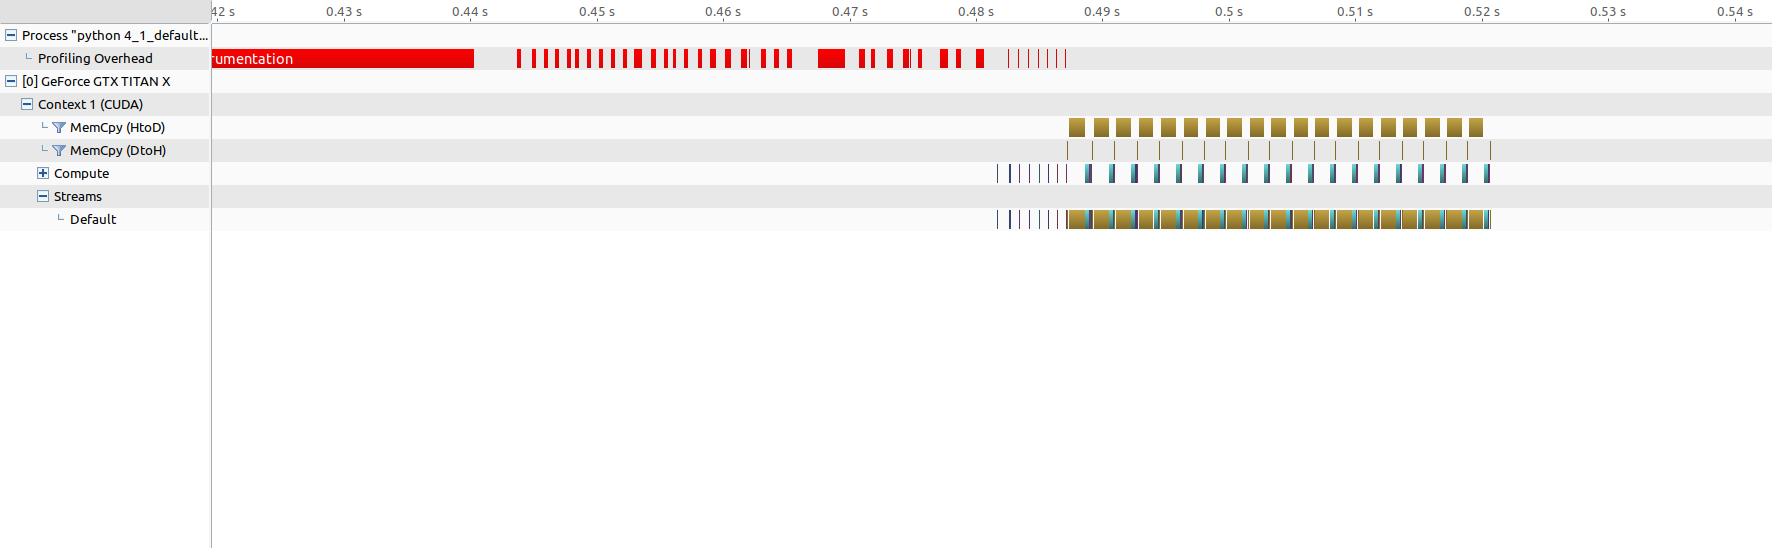

In the image above, we can see the moments of executing the kernels. The kernels were executed one after the other in the order in which they were issued in the Python script, as can be seen in `Streams -> Default` lane. Notice that the stream execution also includes Host to Device (HtoD) and Device to Host (DtoH) transfers (*orange* boxes). 

When using CuPy, we must remember that when we invoke a GPU kernel the first time, kernel's source code is compiled from Python to the GPU machine code. Subsequent calls invokes previously compiled (and cached) code. Therefore some sparsity in first call invocation can be seen in the profiler, just like the in the picture below.

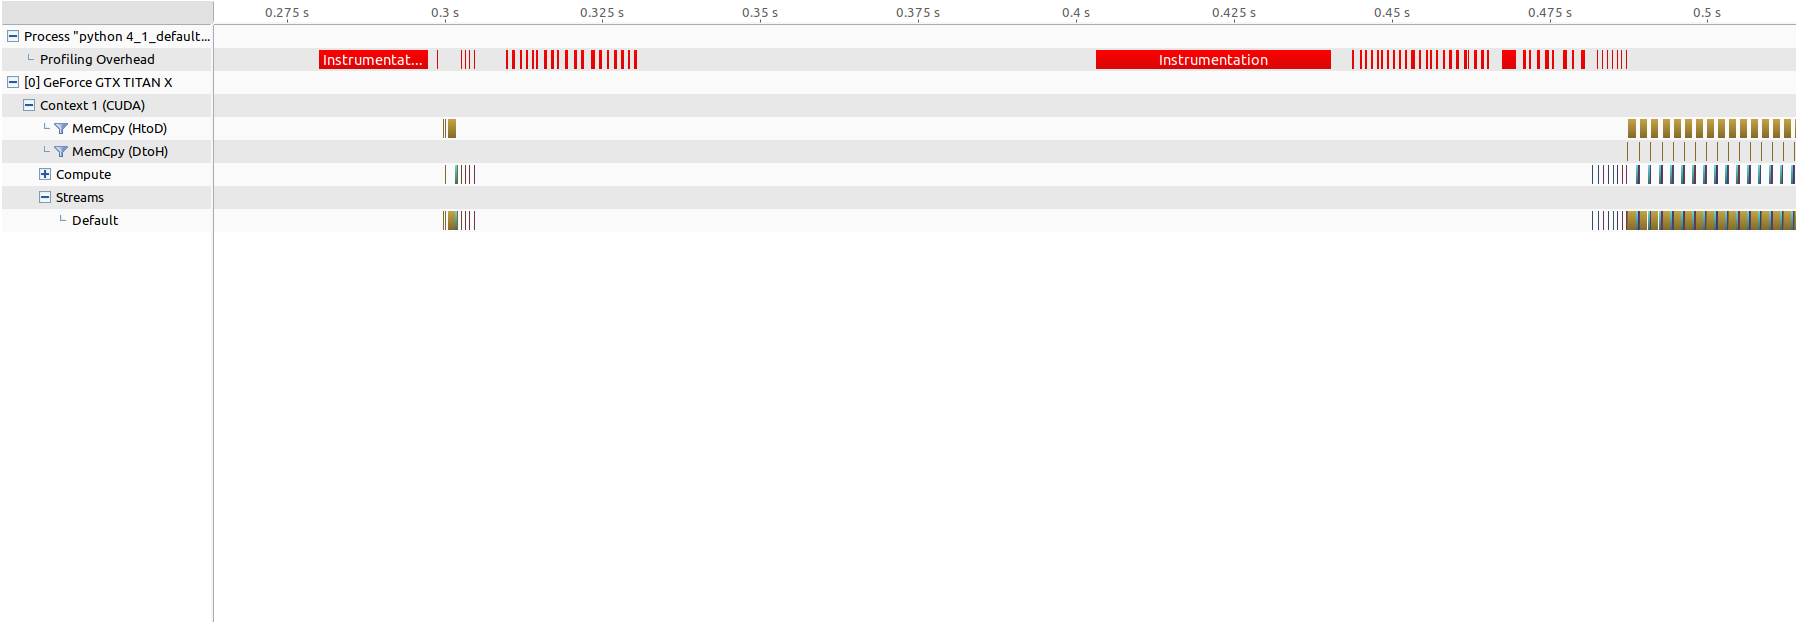

## 4.2. Custom CUDA streams

When using a single stream (e.g. the default stream), the kernels are executed one after the other, in the issue-order. Within a single stream, kernels cannot run in parallel, even if their results are independent of each other. 

If you want to run some kernels in parallel, you need to create a custom CUDA streams.

CUDA programming toolkit provides means to create a custom stream with a specific parameters. To create CUDA stream in CuPy, create an instance of [`cupy.cuda.Stream`](https://docs.cupy.dev/en/stable/reference/generated/cupy.cuda.Stream.html).

The `cupy.cuda.Stream` class has the following parameters:
- `null` - True if the stream is the legacy default stream,
- `ptds` - True if the stream is per thread default stream,
- `non_blocking` - True, if the stream should not synchronize with the `null` stream (e.g. should wait until null stream finishes its jobs). 

Within stream you can run:
- data transfers - use `ndarray.set()` function, set parameter `stream`,
- kernels - use `stream` with keyword,
- functions executed on host - use `cupy.cuda.Stream.launch_host_func`.

### 4.2.1. Overlapping streams

The below example creates two concurrent streams for the vector addition and ultrasound imaging. As you can see, we simply create two CUDA streams, and perform two sequences of different operations on them:

- `ultrasound_imaging_stream`: the previously described imaging pipeline,
- `add_vectors_stream`:  we simply use the CuPy's implementation of `+` operator.

In [144]:
%%writefile 4_2_concurrent_streams.py
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from gpu_short_course.ultrasound_imaging import (
    Beamformer, Hilbert, ToBmode,
    X_GRID, Z_GRID, show_cineloop)
import pickle

file = pickle.load(open("pwi_field2_sample_data.pkl", "rb"))
rfs, context = file["rf"], file["context"]

beamformer = Beamformer(X_GRID, Z_GRID, context, rfs[0].shape)
hilbert    = Hilbert()
to_bmode   = ToBmode()

ultrasound_imaging_stream = cp.cuda.Stream(non_blocking=True)
add_vectors_stream        = cp.cuda.Stream(non_blocking=True) 

# Input data
us_input = cp.empty(shape=rfs[0].shape, dtype=rfs[0].dtype)

a = cp.random.rand(2**24, dtype=cp.float32)
b = cp.random.rand(2**24, dtype=cp.float32)
c = cp.zeros(a.shape, dtype=a.dtype)

for rf in rfs:
    with ultrasound_imaging_stream:
        us_input.set(rf)
        img      = beamformer.process(us_input)
        envelope = hilbert.process(img)
        bmode    = to_bmode.process(envelope)
    with add_vectors_stream:
        a+b
ultrasound_imaging_stream.synchronize()
add_vectors_stream.synchronize()

Overwriting 4_2_concurrent_streams.py


In [145]:
! nvprof --trace gpu --export-profile 4_2_concurrent_streams.nvvp -f python 4_2_concurrent_streams.py

==27303== NVPROF is profiling process 27303, command: python 4_2_concurrent_streams.py
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
==27303== Generated result file: /home/pjarosik/src/us4useu/ius-2021-gpu-short-course/exercises/cupy/4_CUDA_streams_and_processing/4_2_concurrent_streams.nvvp


In the image below, we can see how both streams can be executed concurrently. The `a+b` operation is shown in the figure below and has a name `cupy_add_float32_float32_float32`


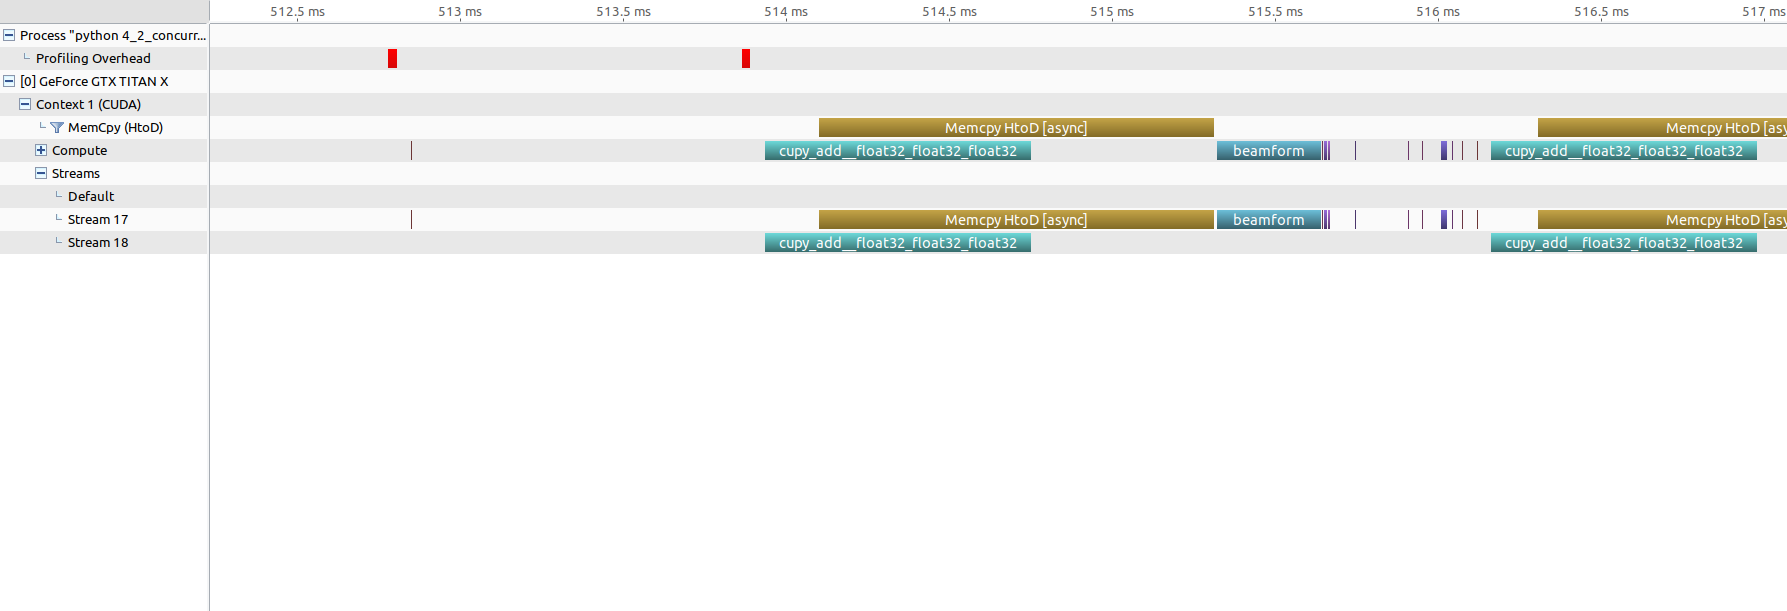

As you can see in the figure abovre, we were able to concurrently do the `a+b` operation, and to transfer data beamformer input data. CUDA stream concurrency may depend on the resources available on the GPU. In some situtations a concurrency may not be possible, for example one of the streams may wait until required resources are available.

## 4.2.2. Overlapping data transfers with processing

One of the most common use cases for concurrent streams is to parallelize data transfer and data processing.

GPU cards have a separate data transfer (DMA) engines that can work in parallel with GPU streaming multiprocessors. Let's suppose that $t_t$ is the time it takes to transfer data between host and GPU (*the transfer time*), and $t_p$ is the time needed to execute all GPU kernels (*processing time*). 

If we perform data transfers and processing on the same stream, the total time to execute all GPU activities and obtain the result will be equal:

$t_t + t_p$

f we perform data transfers and processing in the separate, parallel stream, the total time to execute all GPU activities and obtain the result will be equal:

$\max\{t_t, t_p\}$

Generally, if we want to get the best performance, e.g. to get highest frame rate, our goal is to maximize the activity of all GPU components. Therefore, the second option, in which we can force the simultaneous operation of DMA and multiprocessors, is the preferred one.

To be able to overlap data transfers with processing, we need to describe you (briefly) the following two concepts used in CUDA API: 
- pinned memory,
- CUDA events.

**Pinned memory**

To get the highest bandwith, and to be able to run data transfers and CUDA kernels in the same time, an input data on host (i.e. the `rfs` array from the previous examples) should be *page-locked*. Page-locked memory is always stored in the physical host's memory (i.e. RAM), and accessing it should not generate page faults on access (i.e. because the data is in swap memory). Using pinned memory improves performance, however page-locking should not be overused, as the overall operating system's performance can be reduced. 

To page-lock and release host memory in CuPy use `cp.cuda.runtime.hostRegister` function. To release page-locking, use `cp.cuda.runtime.hostUnregister`. 

You can read more about the pinned memory [here](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#pinned-memory).

**CUDA events**

CUDA event object represents some event in the CUDA stream execution timeline. An example of such event is the completion of some GPU kernel, or that the data transfer from host to GPU has finished.

In CuPy, you can create (an empty) Event object using `event = cp.cuda.Event()`.

CUDA API (and CuPy) provides functions, that allows to:
- record the current moment of a stream execution to an object of the type `cp.cuda.Event() (using `event.record(stream)`,
- to tell, the stream should wait until some event occurs.

Importantly, **streams can wait for events in other streams**. Thanks to this, we have the ability to synchronize the activities of different streams.

For example, suppose we have the following two streams:
- `host_to_device_data_stream`: for data transfer from host to GPU,
- `processing_stream` on GPU kernels.
We would like data processing to start only when the transfer is completed first. We can do something like this:

```python
gpu_array.set(rf,    stream=host_to_device_data_stream) # Start HtoD transfer first (async).
data_is_ready.record(stream=host_to_device_data_stream) # Now, let's record the event (that is, the event will be triggered after the HtoD transfer).
processing_stream.wait_event(data_is_ready)             # Processing stream should wait until the event is triggered.
with processing_stream:
    some_processing(gpu_array)
```
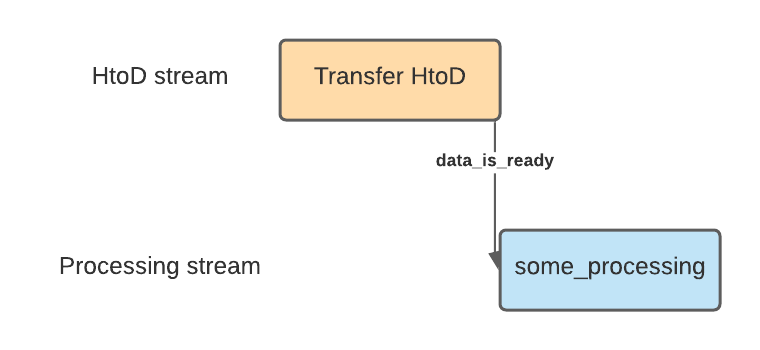


We will use the above approach with events in our scripts.

OK, now we are ready to implement a script that overlaps `HtoD` transfers and GPU processing. 

Note that, to be able to run data transfer and processing in the same time, we need to have at least two GPU arrays: one to which the processing will be performed, the second as a workspace for processing. In the Python script below, we create two GPU arrays in the variable `input_buffer`, and cyclically change between them (i.e. we use element `input_buffer[i%2]` for `i`-th RF frame). 

The script below demonstrates an attempt to parallelize data transfer and processing:

In [147]:
%%writefile 4_2_concurrent_transfers_processing.py
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from gpu_short_course.ultrasound_imaging import (
    Beamformer, Hilbert, ToBmode,
    X_GRID, Z_GRID, show_cineloop)
import pickle

file = pickle.load(open("pwi_field2_sample_data.pkl", "rb"))
rfs, context = file["rf"], file["context"]

# processing
beamformer = Beamformer(X_GRID, Z_GRID, context, rfs[0].shape)
hilbert    = Hilbert()
to_bmode   = ToBmode()

# Streams
host_to_device_data_stream = cp.cuda.Stream(non_blocking=True)
processing_stream          = cp.cuda.Stream(non_blocking=True)

# Here we create two GPU arrays for 
input_buffer = [cp.zeros(rfs[0].shape, dtype=cp.float32),
                cp.zeros(rfs[0].shape, dtype=cp.float32)]
input_buffer_ready = [cp.cuda.Event(), cp.cuda.Event()]

# Page-lock host data.
for rf in rfs:
    ptr = rf.ctypes.data
    nbytes = rf.nbytes
    cp.cuda.runtime.hostRegister(ptr, nbytes, 1)


for i, rf in enumerate(rfs):
    rf_gpu       = input_buffer[i%2]
    rf_gpu_ready = input_buffer_ready[i%2]

    # Transfer data asynchronously - that is, host doesn't wait here for the transfer to finish. 
    rf_gpu.set(rf, stream=host_to_device_data_stream)
    rf_gpu_ready.record(stream=host_to_device_data_stream)
    processing_stream.wait_event(rf_gpu_ready)
    with processing_stream:
        img      = beamformer.process(rf_gpu)
        envelope = hilbert.process(img)
        bmode    = to_bmode.process(envelope)
        
# Wait until all the GPU processing is done.
host_to_device_data_stream.synchronize()
processing_stream.synchronize()

# Unlock host data.
for rf in rfs:
    ptr = rf.ctypes.data
    cp.cuda.runtime.hostUnregister(ptr)

Overwriting 4_2_concurrent_transfers_processing.py


In [148]:
! nvprof --trace gpu --export-profile 4_2_concurrent_transfers_processing.nvvp -f python 4_2_concurrent_transfers_processing.py

==27426== NVPROF is profiling process 27426, command: python 4_2_concurrent_transfers_processing.py
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
==27426== Generated result file: /home/pjarosik/src/us4useu/ius-2021-gpu-short-course/exercises/cupy/4_CUDA_streams_and_processing/4_2_concurrent_transfers_processing.nvvp


Here is what we have seen in NVIDIA Visual Profiler.

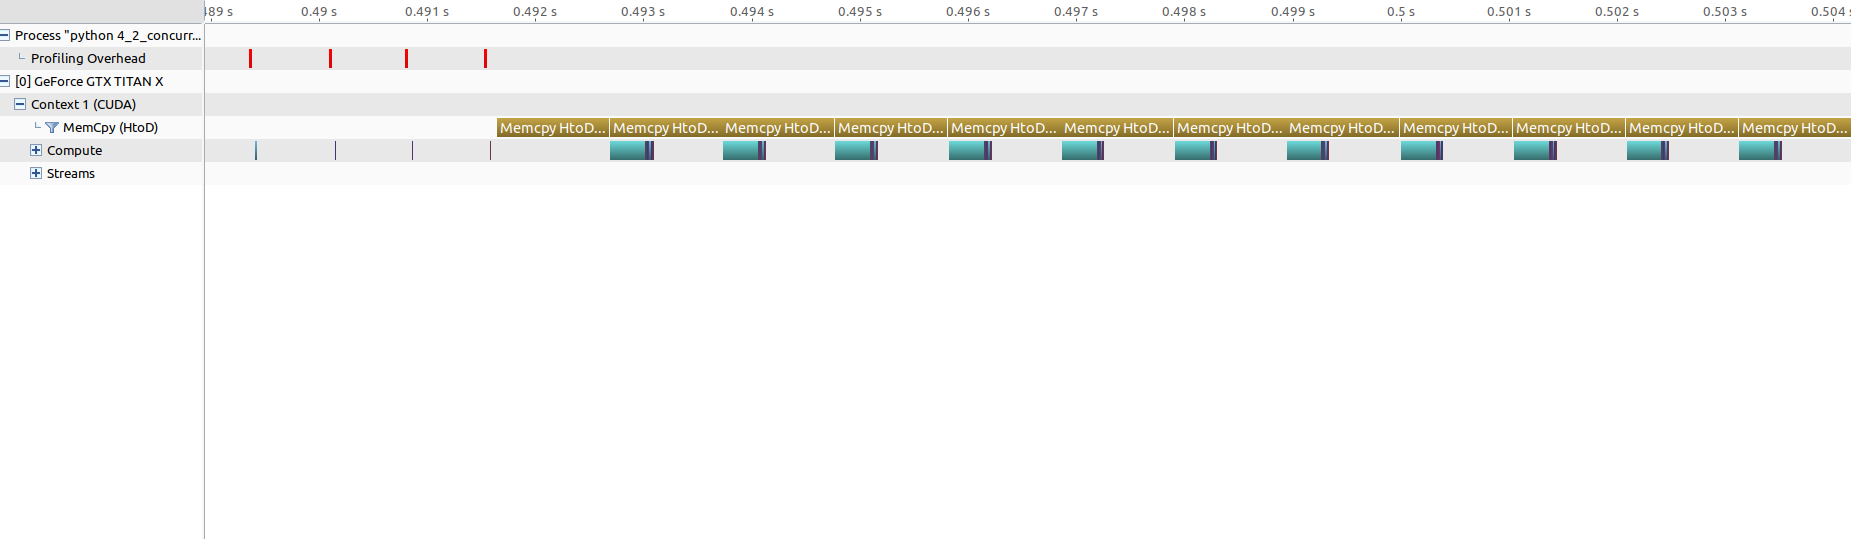

As we can see above, we were able to run data transfer and processing in parallel. 

Now let's try to make the data processing to take longer than the HtoD transfer (note: we are using NVIDIA Titan X here). In our case, it was enough to start processing with 1D convolve:

In [151]:
%%writefile 4_2_concurrent_transfers_processing_long.py
import numpy as np
import cupy as cp
import scipy.signal
import cupyx.scipy.ndimage
import matplotlib.pyplot as plt
from gpu_short_course.ultrasound_imaging import Beamformer, Hilbert, ToBmode, X_GRID, Z_GRID, show_cineloop
from gpu_short_course.tools import register_host_buffer, unregister_host_buffer
import pickle

file = pickle.load(open("pwi_field2_sample_data.pkl", "rb"))
rfs, context = file["rf"], file["context"]
transmit_frequency = context["transmit_frequency"]
sampling_frequency = context["sampling_frequency"]

# processing
beamformer = Beamformer(X_GRID, Z_GRID, context, rfs[0].shape)
hilbert    = Hilbert()
to_bmode   = ToBmode()

# Streams
host_to_device_data_stream = cp.cuda.Stream(non_blocking=True)
processing_stream          = cp.cuda.Stream(non_blocking=True)

input_buffer = [cp.zeros(rfs[0].shape, dtype=cp.float32),
                cp.zeros(rfs[0].shape, dtype=cp.float32)]
input_buffer_ready = [cp.cuda.Event(), cp.cuda.Event()]

register_host_buffer(rfs)

filter_order = 64
filter_coeffs = scipy.signal.firwin(filter_order, np.array([0.5, 1.5])*transmit_frequency, pass_zero=False, fs=sampling_frequency)
filter_coeffs = cp.asarray(filter_coeffs)

for i, rf in enumerate(rfs):
    rf_gpu       = input_buffer[i%2]
    rf_gpu_ready = input_buffer_ready[i%2]

    # Transfer data asynchronously - that is, host doesn't wait here for the transfer to finish. 
    rf_gpu.set(rf, stream=host_to_device_data_stream)
    rf_gpu_ready.record(stream=host_to_device_data_stream)
    processing_stream.wait_event(rf_gpu_ready)
    with processing_stream:
        filtered_rf = cupyx.scipy.ndimage.convolve1d(rf_gpu, filter_coeffs, axis=-1)
        img         = beamformer.process(rf_gpu)
        envelope    = hilbert.process(img)
        bmode       = to_bmode.process(envelope)
        
processing_stream.synchronize()
host_to_device_data_stream.synchronize()
unregister_host_buffer(rfs)

Overwriting 4_2_concurrent_transfers_processing_long.py


In [152]:
! nvprof --trace gpu --export-profile 4_2_concurrent_transfers_processing_long.nvvp -f python 4_2_concurrent_transfers_processing_long.py

==27522== NVPROF is profiling process 27522, command: python 4_2_concurrent_transfers_processing_long.py
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
==27522== Generated result file: /home/pjarosik/src/us4useu/ius-2021-gpu-short-course/exercises/cupy/4_CUDA_streams_and_processing/4_2_concurrent_transfers_processing_long.nvvp


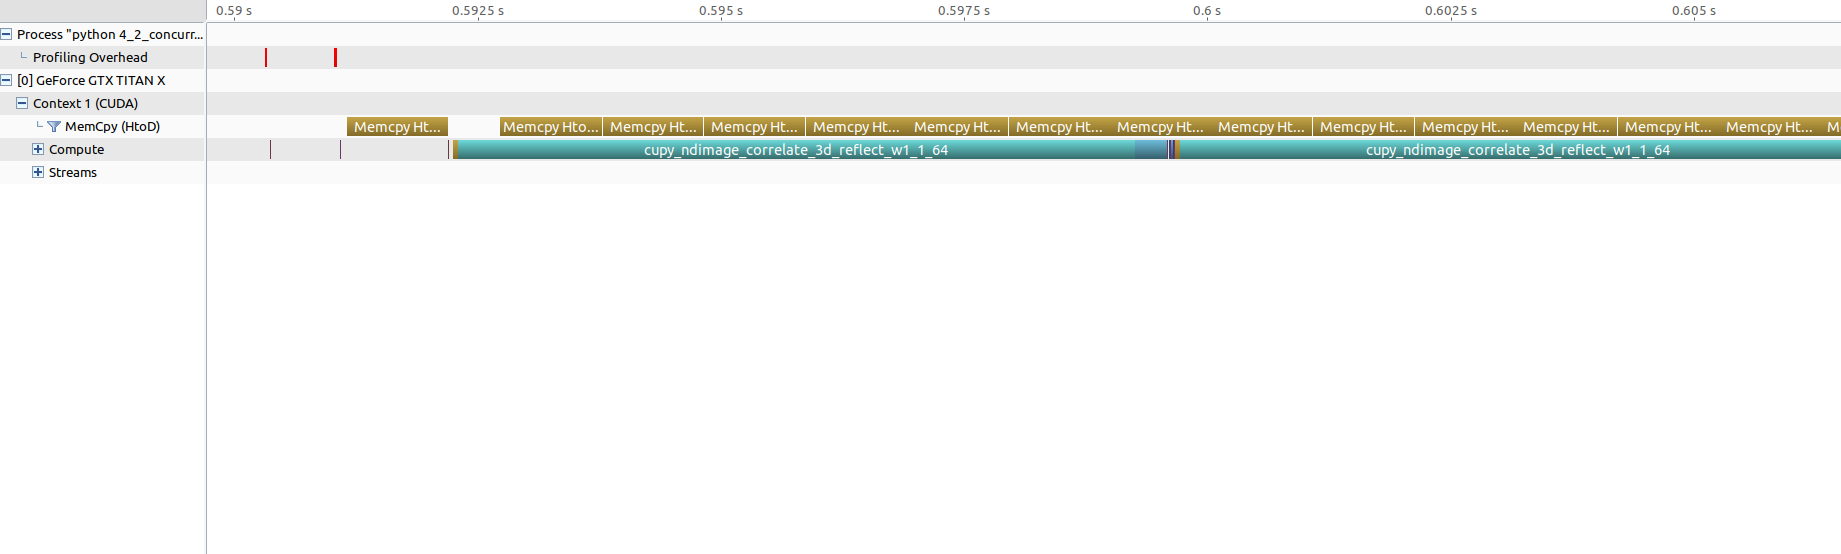

As we can see above, in the above case we were also able to run data transfer and processing in parallel. 

However, are you sure the above script works correctly? Is there anything wrong with the above graph?

Please notice, that in the above example, the data is copied to GPU faster than it is processed. This means that the memcpy stream will overwrite eventually data that has not yet been processed.

This is a typical issue when the producer (GPU transfer stream in our case) produces the data faster than the consumer (our imaging stream) can process it. 

There are several solution to that problem:
- producer can wait until the consumer releases the given memory area,
- producer can raise an error when notice, that it is writing to memory area that is still in use (this can be required for time-critical applications),
- we can slow down the producer (e.g. artificially adding some delay),
- we can speed up the consumer (e.g. use a better GPU card, improve kernel performance, etc.), 
- ... and so on. 

Some of them will be described in the following section.

## 4.3. Producer - consumer

In the producer - consumer problem we consider here, we have:
- producer: a *process*, that produces some data (e.g. ultrasound system),
- consumer: a *process*, that consumes the data generated by consumer (e.g. GPU),
- buffer: a common workspace for producer and consumer (e.g. some GPU memory area) in which the producer places new data, and from which the consumer gets new data. The buffer is designed to hold a finite amount of data.

In this notebook we will consider only a single producer - single consumer case. 

For example, in the below image, we have a single producer and single consumer, and produces puts new data to 4-element buffer. Note that, if we want the producer and the consumer to work in parallel in a common space, the buffer must be at least two-element.

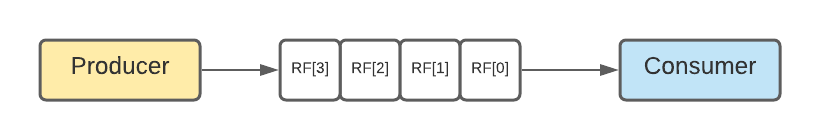

This is a typical situation that occurs when we have an ultrasound system that generates some new data (e.g. raw channel data) that must then be processed by some device (e.g. GPU).

The question is: how can we handle the situation from the previous section, that is, when producer is faster than consumer, and *floods us* with new data?

In this notebook we will consider the following possible solutions:
- producer raise an error on override, 
- producer waits until there is free space for new data.



### 4.3.1. 'Error on override' mode

In 'Error on override mode':
- producer acquires the memory to which he wants to write (using the acquire function in the code below),
- consumer releases memory space, which is no longer needed (i.e. after all processing is done),
- **when a producer tries to acquire memory area that has not yet been released, an error is reported**.

The Python script below:
- creates a `BufferElement` class, which has the following attributes and functions:
  - attribute `occupied`: a boolean value, that will be set to `True` when the item is still in use by GPU,
  - function `acquire`: if `occupied` is True, an error will be raised; otherwise sets `occupied` to True, 
  - function `release`: if sets `occupied` to False.

The 'Error on override mode' is necessary when you have to be sure, that no data was lost, e.g. because our GPU code is processing data to slowly. This approach also forces us to keep our application in hard real-time regime - our GPU code must always process data within a strictly defined time frame, jitter during processing is not allowed. Failure to do so may result in an error.

Here is the code that implements this simple approach:

In [153]:
%%writefile 4_3_concurrent_transfers_processing_error_on_override.py
import numpy as np
import cupy as cp
import scipy.signal
import cupyx.scipy.ndimage
import matplotlib.pyplot as plt
from gpu_short_course.ultrasound_imaging import UltrasoundImaging
from gpu_short_course.tools import register_host_buffer, unregister_host_buffer
import pickle


# Read the input data.
file = pickle.load(open("pwi_field2_sample_data.pkl", "rb"))
rfs, context = file["rf"], file["context"]
frame_shape = rfs[0].shape
frame_dtype = rfs[0].dtype

# Page-lock input data.
register_host_buffer(rfs)


# ------------------ GPU BUFFER ------------------
class BufferElement:
    """
    This class represents a single element of data buffer.
    Acquiring the element when it's not released will end up with
    an "buffer override" exception.
    """

    def __init__(self, data):
        self.data = data
        self.occupied = False
        self.is_ready = cp.cuda.Event()

    def acquire(self):
        if self.occupied:
            raise ValueError("GPU buffer override")
        self.occupied = True

    def release(self):
        self.occupied = False
        
        
gpu_buffer = [BufferElement(cp.zeros(frame_shape, dtype=frame_dtype)),
              BufferElement(cp.zeros(frame_shape, dtype=frame_dtype))]

# Imaging pipeline that converts data into B-mode images.
imaging = UltrasoundImaging(context, filter_order=64, frame_shape=frame_shape)

# Streams
host_to_device_data_stream = cp.cuda.Stream(non_blocking=True)
processing_stream          = cp.cuda.Stream(non_blocking=True)


# Run the imaging pipeline for RF data.
for i, rf in enumerate(rfs):
    element       = gpu_buffer[i%2]
    # Acquire buffer element.
    # If the buffer element is still occupied by processing, here we will get error.
    element.acquire()
    
    # Transfer RF data to the given GPU buffer element.
    element.data.set(rf, stream=host_to_device_data_stream)
    # Processing stream should wait until the buffer element is ready.
    element.is_ready.record(stream=host_to_device_data_stream)
    processing_stream.wait_event(element.is_ready)
    
    # Now invoke the processing.
    with processing_stream:
        bmode = imaging.process(element.data)
    # After doing all the processing, release GPU buffer element.
    processing_stream.add_callback(lambda stream, error_status, element: element.release(), element)
        
processing_stream.synchronize()
host_to_device_data_stream.synchronize()

# Clean up.

# Unlock host buffer.
unregister_host_buffer(rfs)

Overwriting 4_3_concurrent_transfers_processing_error_on_override.py


In [154]:
! nvprof --trace gpu --export-profile 4_3_concurrent_transfers_processing_error_on_override.nvvp -f python 4_3_concurrent_transfers_processing_error_on_override.py

==27680== NVPROF is profiling process 27680, command: python 4_3_concurrent_transfers_processing_error_on_override.py
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
Traceback (most recent call last):
  File "4_3_concurrent_transfers_processing_error_on_override.py", line 59, in <module>
    element.acquire()
  File "4_3_concurrent_transfers_processing_error_on_override.py", line 36, in acquire
    raise ValueError("GPU buffer override")
ValueError: GPU buffer override
==27680== Generated result file: /home/pjarosik/src/us4useu/ius-2021-gpu-short-course/exercises/cupy/4_CUDA_streams_and_processing/4_3_concurrent_transfers_processing_error_on_override.nvvp
======== Error: Application returned non-zero code 1


As you can see, we are getting `GPU buffer override` error. Let's we see in NVIDIA Visual Profiler how the processing steps works:

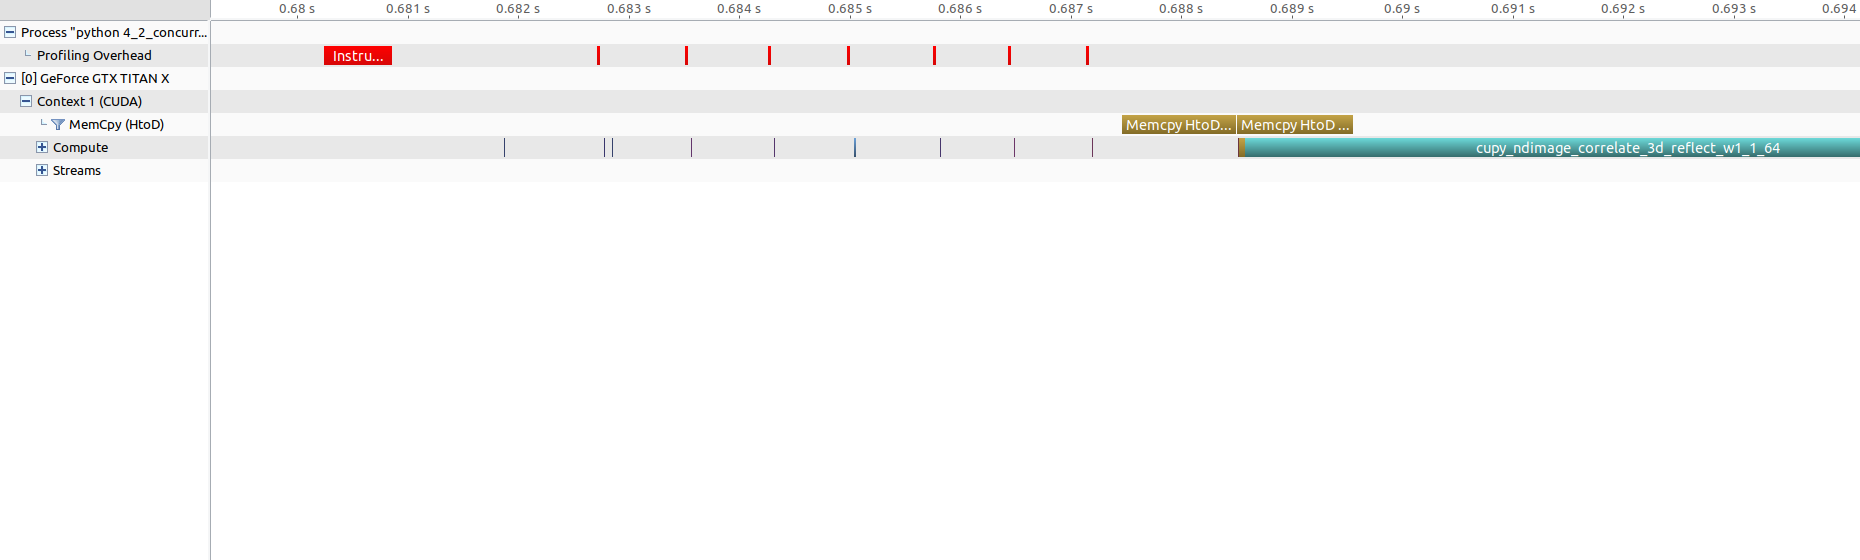

After the second data transfer we get the error and the data processing ends.

### 4.3.2. Lock-based mode

In 'Error on override mode':
- producer acquires the memory to which he wants to write (using the acquire function in the code below),
- consumer releases memory space, which is no longer needed (i.e. after all processing is done),
- **the producer waits until the memory area he wants to write to is free**.

The Python script below:
- creates a `BufferElement` class, which has the following attributes and functions:
  - Attribute `semaphore`: a [semaphore](https://docs.python.org/3/library/threading.html#semaphore-example) object with two states: acquired and released. 
  - Function `acquire`: acquires the semaphore object. If the semaphore has already been acquired but not yet released, this function blocks the currently executing thread.
  - Function `release`: releases semaphore object, notify the blocked thread that the semaphore is free.


This mode applies for use cases, where the data acquisition time can be automatically determined by processing time. This solution can introduce some jitter during data acquisition when processing is performed on the GPU.

Here is the code that implements that approach:

In [155]:
%%writefile 4_3_concurrent_transfers_processing_lock_until_available.py
import threading
import numpy as np
import cupy as cp
import scipy.signal
import cupyx.scipy.ndimage
import matplotlib.pyplot as plt
from gpu_short_course.ultrasound_imaging import UltrasoundImaging
from gpu_short_course.tools import register_host_buffer, unregister_host_buffer
import pickle


# Read the input data.
file = pickle.load(open("pwi_field2_sample_data.pkl", "rb"))
rfs, context = file["rf"], file["context"]
frame_shape = rfs[0].shape
frame_dtype = rfs[0].dtype

# Page-lock input data.
register_host_buffer(rfs)


# ------------------ GPU BUFFER ------------------
class BufferElement:
    """
    This class represents a single element of data buffer.
    Acquiring the element when it's not released will end up with
    an "buffer override" exception.
    """

    def __init__(self, data):
        self.data = data
        self.semaphore = threading.Semaphore()
        self.is_ready = cp.cuda.Event()

    def acquire(self):
        self.semaphore.acquire()

    def release(self):
        self.semaphore.release()

        
gpu_buffer = [BufferElement(cp.zeros(frame_shape, dtype=frame_dtype)),
              BufferElement(cp.zeros(frame_shape, dtype=frame_dtype))]

# Imaging pipeline that converts data into B-mode images.
imaging = UltrasoundImaging(context, filter_order=64, frame_shape=frame_shape)

# Streams
host_to_device_data_stream = cp.cuda.Stream(non_blocking=True)
processing_stream          = cp.cuda.Stream(non_blocking=True)


# Run the imaging pipeline for RF data.
for i, rf in enumerate(rfs):
    
    element       = gpu_buffer[i%2]
    # Acquire buffer element.
    # If the buffer element is still occupied by processing, here we will get error.
    element.acquire()
    
    # Transfer RF data to the given GPU buffer element.
    element.data.set(rf, stream=host_to_device_data_stream)
    # Processing stream should wait until the buffer element is ready.
    element.is_ready.record(stream=host_to_device_data_stream)
    processing_stream.wait_event(element.is_ready)
    
    # Now invoke the processing.
    with processing_stream:
        bmode = imaging.process(element.data)
    # After doing all the processing, release GPU buffer element.
    processing_stream.add_callback(lambda stream, error_status, element: element.release(), element)
        
processing_stream.synchronize()
host_to_device_data_stream.synchronize()

# Clean up.

# Unlock host buffer.
unregister_host_buffer(rfs)

Overwriting 4_3_concurrent_transfers_processing_lock_until_available.py


In [156]:
! nvprof --trace gpu --export-profile 4_3_concurrent_transfers_processing_lock_until_available.nvvp -f python 4_3_concurrent_transfers_processing_lock_until_available.py

==27730== NVPROF is profiling process 27730, command: python 4_3_concurrent_transfers_processing_lock_until_available.py
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
==27730== Generated result file: /home/pjarosik/src/us4useu/ius-2021-gpu-short-course/exercises/cupy/4_CUDA_streams_and_processing/4_3_concurrent_transfers_processing_lock_until_available.nvvp


And here is the example result of profiling:

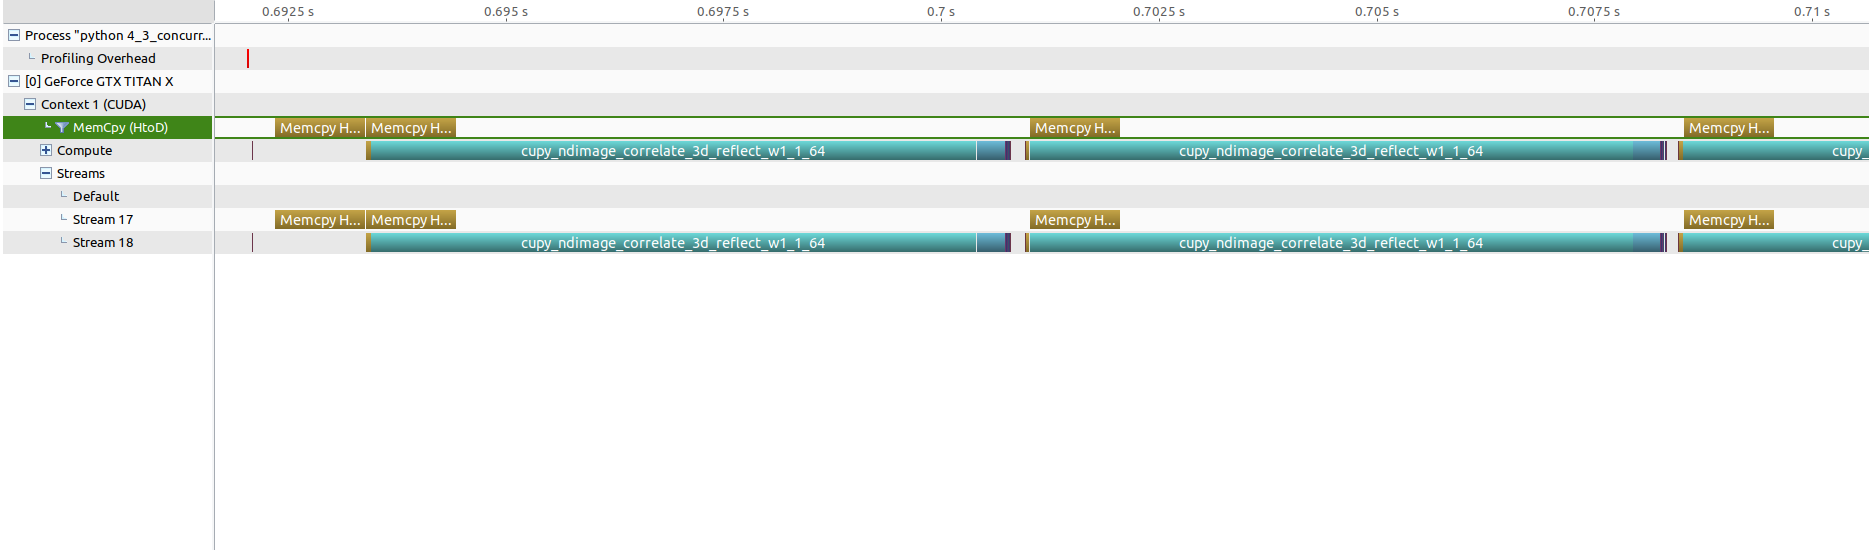

As you can see above, data transfers waits for data processing to end.

# References

- 